In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd

# Problem 1

In [464]:
data=np.loadtxt("MiniBooNE_PID.txt",skiprows=1)

# Few entries has -999 as values, replace them by nan
data=np.where(data==-999,np.nan,data)
# no of elements in each category
num_elems=np.loadtxt("MiniBooNE_PID.txt",max_rows=1,dtype=int)

In [465]:
data=data.T # Transpose data features are in the rows and each entry is in a column.

In [466]:
row_means = np.nanmean(data, axis=1)
data[np.isnan(data)] = np.take(row_means, np.isnan(data).nonzero()[0])

In [467]:
num_elems # First entry number of entries of signal, second number is number of entries of background

array([36499, 93565])

In [468]:
n1=num_elems[0]
n0=num_elems[1]
prior=num_elems/sum(num_elems)
prior

array([0.28062339, 0.71937661])

In [469]:
# Create vector of labels
y=np.hstack((np.ones(n1),np.zeros(n0)))

In [470]:
mean1=np.mean(data[:,:n1],axis=1)
mean0=np.mean(data[:,n1:],axis=1)
std1=np.std(data[:,:n1],axis=1)
std0=np.std(data[:,n1:],axis=1)


In [471]:
def gaussian(x,type):
    if type==1:
        return np.exp(-(1/2)*(np.power((x-mean1)/std1,2)))/np.sqrt(2*np.pi*std1)
    else:
        return np.exp(-(1/2)*(np.power((x-mean0)/std0,2)))/np.sqrt(2*np.pi*std0)

In [472]:
def predict(x):
    p1=prior[0]*np.prod(gaussian(x,1))
    p0=prior[1]*np.prod(gaussian(x,0))
    if p1>p0:
        return 1
    else:
        return 0

In [473]:
def f1_score(actual,predicted):
    recall_1=sum(predicted[:n1])/n1
    recall_0=sum(1-predicted[n1:])/n0
    precision_1=sum(predicted[:n1])/sum(predicted)
    precision_0=sum(1-predicted[n1:])/sum(1-predicted)
    f1_1=2/((1/recall_1)+(1/precision_1))
    f1_0=2/((1/recall_0)+(1/precision_0))
    print(recall_1,recall_0)
    print(precision_1,precision_0)
    print(f"F1-Score for signal {f1_1}")
    print(f"F1-Score for background {f1_0}")

In [474]:
predicted=[]
for i in range(data.shape[1]):
    predicted.append(predict(data[:,i]))

In [475]:
predicted=np.array(predicted)

In [476]:
f1_score(y,predicted)

0.895531384421491 0.7890984876823599
0.6235525286632709 0.9508918797089316
F1-Score for signal 0.7351942238916754
F1-Score for background 0.862472986390982


## Gmm

In [15]:
def gaussian_gmm(x,mean,std):
    return np.exp(-(1/2)*(np.power((x-mean)/std,2)))/np.sqrt(2*np.pi*std)

In [29]:
x=data[5,:n1].copy()
x

array([0.374393, 0.361239, 0.260841, ..., 0.469154, 0.144113, 0.342888])

<AxesSubplot: ylabel='Density'>

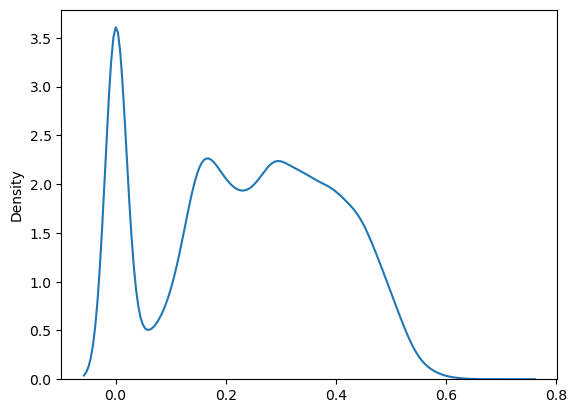

In [30]:
import seaborn as sns
sns.kdeplot(x)

In [19]:
((prior*gaussian_gmm(x[i],mean,variance))/(prior*gaussian_gmm(x[i],mean,variance)).sum())

IndexError: index 130063 is out of bounds for axis 0 with size 36499

In [22]:
import warnings

In [31]:
k=3
n=len(x)
mean,variance,prior=np.random.rand(k),np.random.rand(k),(1/k)*np.ones(k)
responsibility=np.zeros((n,k))

In [32]:
for i in range(5):
    for i in range(n):
        for j in range(k):
            #responsibility[i,:]=(prior*gaussian_gmm(x[i],mean,variance))/(prior*gaussian_gmm(x[i],mean,variance)).sum()
            with warnings.catch_warnings(record=True) as w:
                responsibility[i,:]=(prior*gaussian_gmm(x[i],mean,np.sqrt(variance)))/(prior*gaussian_gmm(x[i],mean,np.sqrt(variance))).sum()
                if len(w) > 0:
                    z=x[i]
                    print(x[i])
                    print(mean,variance)
                    print((gaussian_gmm(x[i],mean,variance)))
                    print ((prior*gaussian_gmm(x[i],mean,variance)).sum())
    N_k=np.sum(responsibility,axis=0)
    prior=N_k/len(x)
    mean=(responsibility*x.reshape(len(x),1)).sum(axis=0)/N_k
    for v in range(len(variance)):
        variance[v]=(responsibility[:,v]*((x-mean[v])**2)).sum()/N_k[v]
    # if len(w)>0:
    #     print(N_k)

In [33]:
N_k=np.sum(responsibility,axis=0)
prior=N_k/len(x)
mean=(responsibility*x.reshape(len(x),1)).sum(axis=0)/N_k
for v in range(len(variance)):
    variance[v]=(responsibility[:,v]*((x-mean[v])**2)).sum()/N_k[v]
if len(w)>0:
    print(N_k)

In [34]:
mean,variance,prior

(array([0.227493  , 0.38929475, 0.23961709]),
 array([0.02414851, 0.00614267, 0.02406859]),
 array([0.55727409, 0.05578291, 0.386943  ]))

In [28]:
prior,mean,variance

(array([0.12672419, 0.85360939, 0.01966642]),
 array([3.59408799, 3.90192094, 3.29295104]),
 array([0.28286328, 0.5425749 , 0.14910841]))

# Problem 2

In [51]:
files=os.listdir()[2:-1]
images=[]
for i in range(0,len(files)):
    im=Image.open(files[i])
    im=np.array(im.resize((int(im.size[0]/2),int(im.size[1]/2))))
    images.append(im)

In [53]:
def k_means_segm(im,k=3,maxIter=10,eps=0.01):
    n1=im.shape[0]
    n2=im.shape[1]
    img=im.copy()
    L=np.random.randint(0,k,(n1,n2))
    d=3
    prev_means=np.zeros((d,k))
    for iters in range(maxIter):
        count=np.zeros(k,dtype=int)
        means=np.zeros((d,k))
        for i in range(n1):
            for j in range(n2):
                ind=L[i,j]
                count[ind]+=1
                means[:,ind]+=img[i,j]
        if np.linalg.norm(prev_means-means,axis=0).min()<=eps:
            break
        for i in range(len(count)):
            if count[i]==0:
                means[:,i]=prev_means[:,i]
            else:
                means[:,i]=means[:,i]/count[i]
        for i in range(n1):
            for j in range(n2):
                L[i,j]=np.argmin(np.linalg.norm(means-im[i,j].reshape(3,1),axis=0))
        prev_means=means.copy()
    for i in range(n1):
        for j in range(n2):
            img[i,j]=means[:,L[i,j]]
    return img

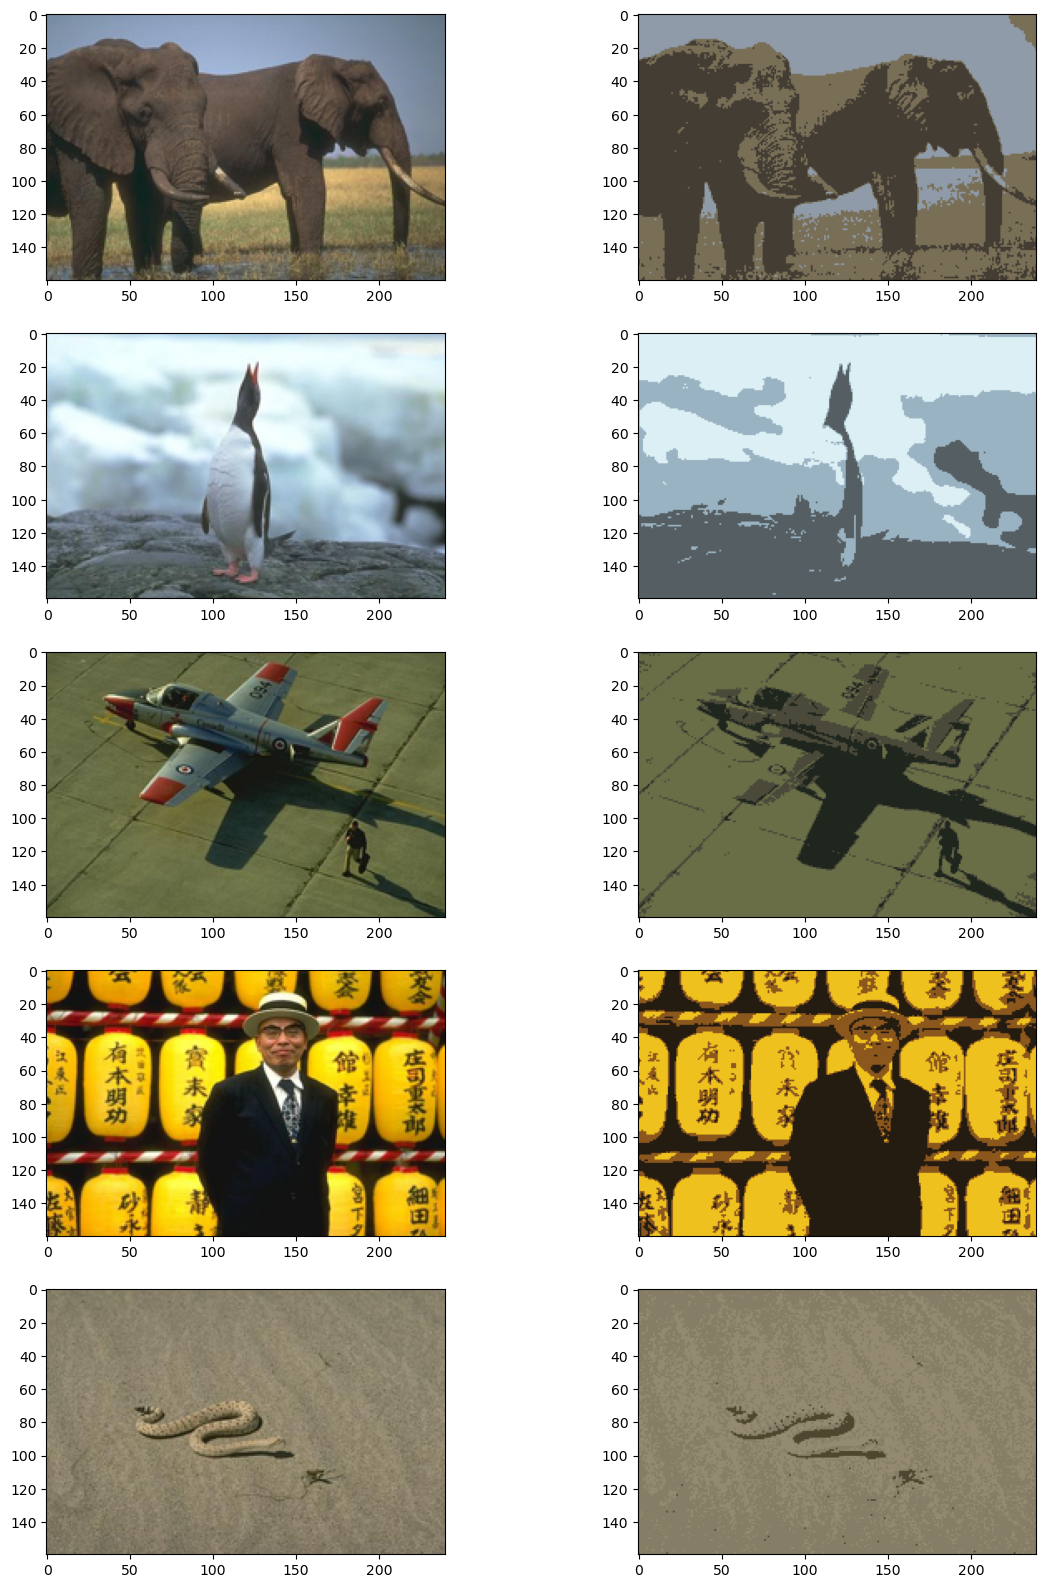

In [54]:
fig,axes=plt.subplots(5,2,figsize=(14,20))
for i in range(5):
    axes[i,0].imshow(images[i])
    axes[i,1].imshow(k_means_segm(images[i]))

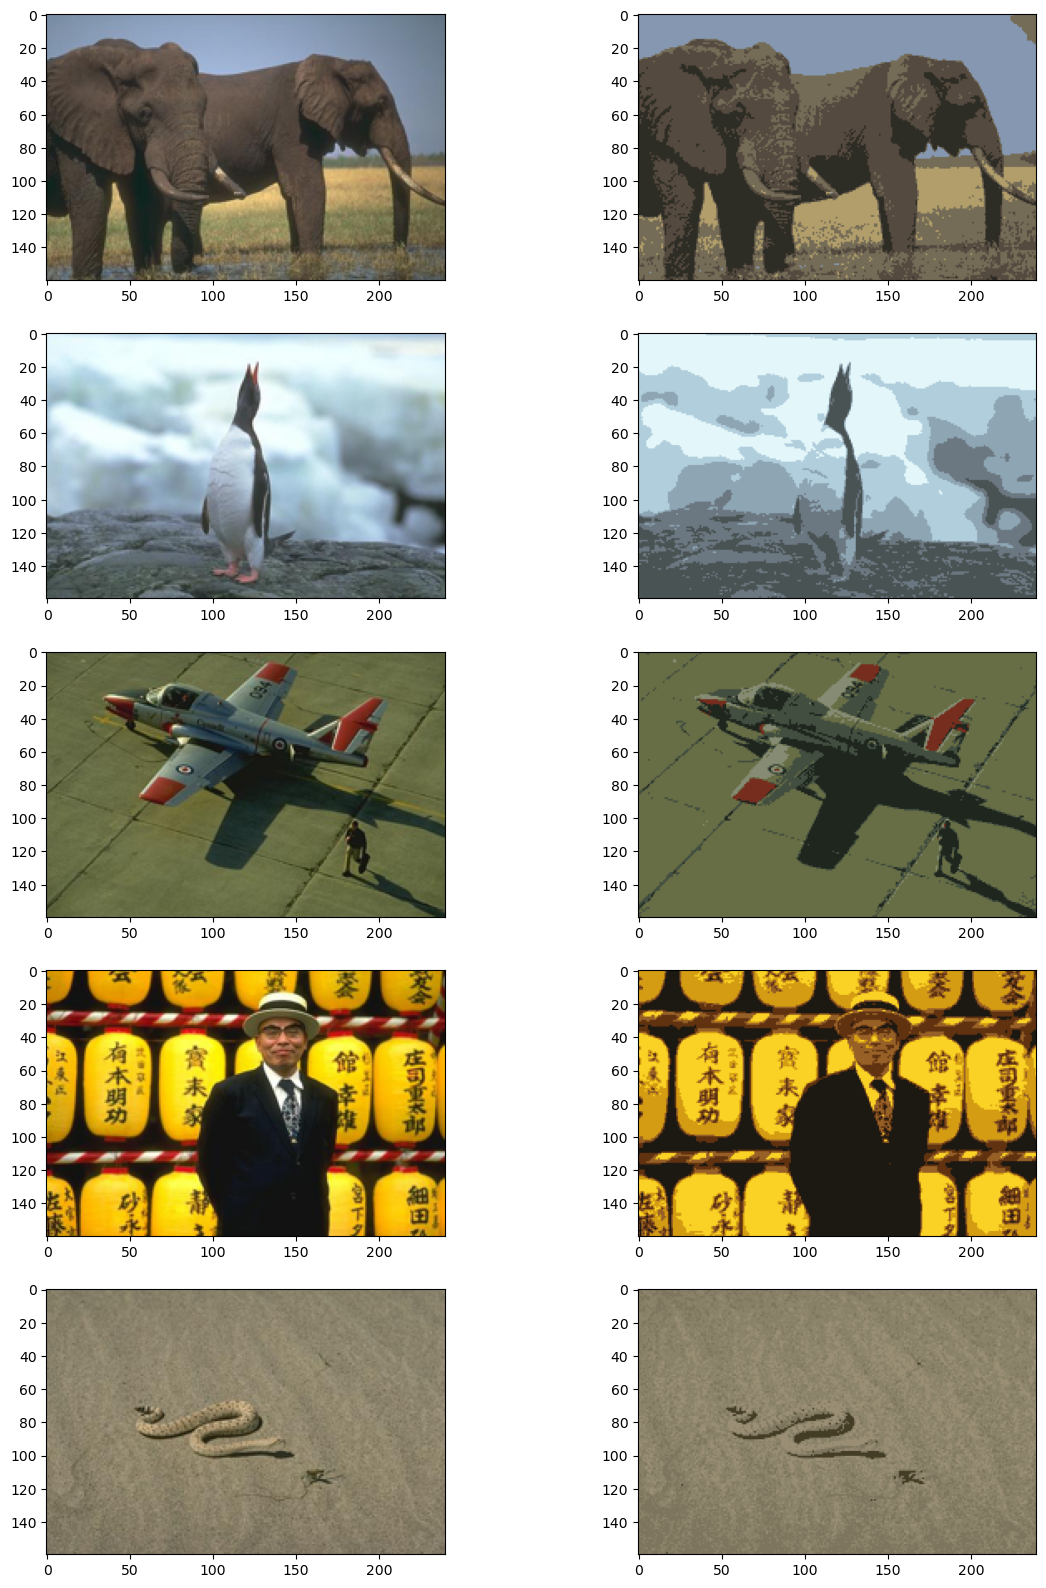

In [55]:
fig,axes=plt.subplots(5,2,figsize=(14,20))
for i in range(5):
    axes[i,0].imshow(images[i])
    axes[i,1].imshow(k_means_segm(images[i],k=5))

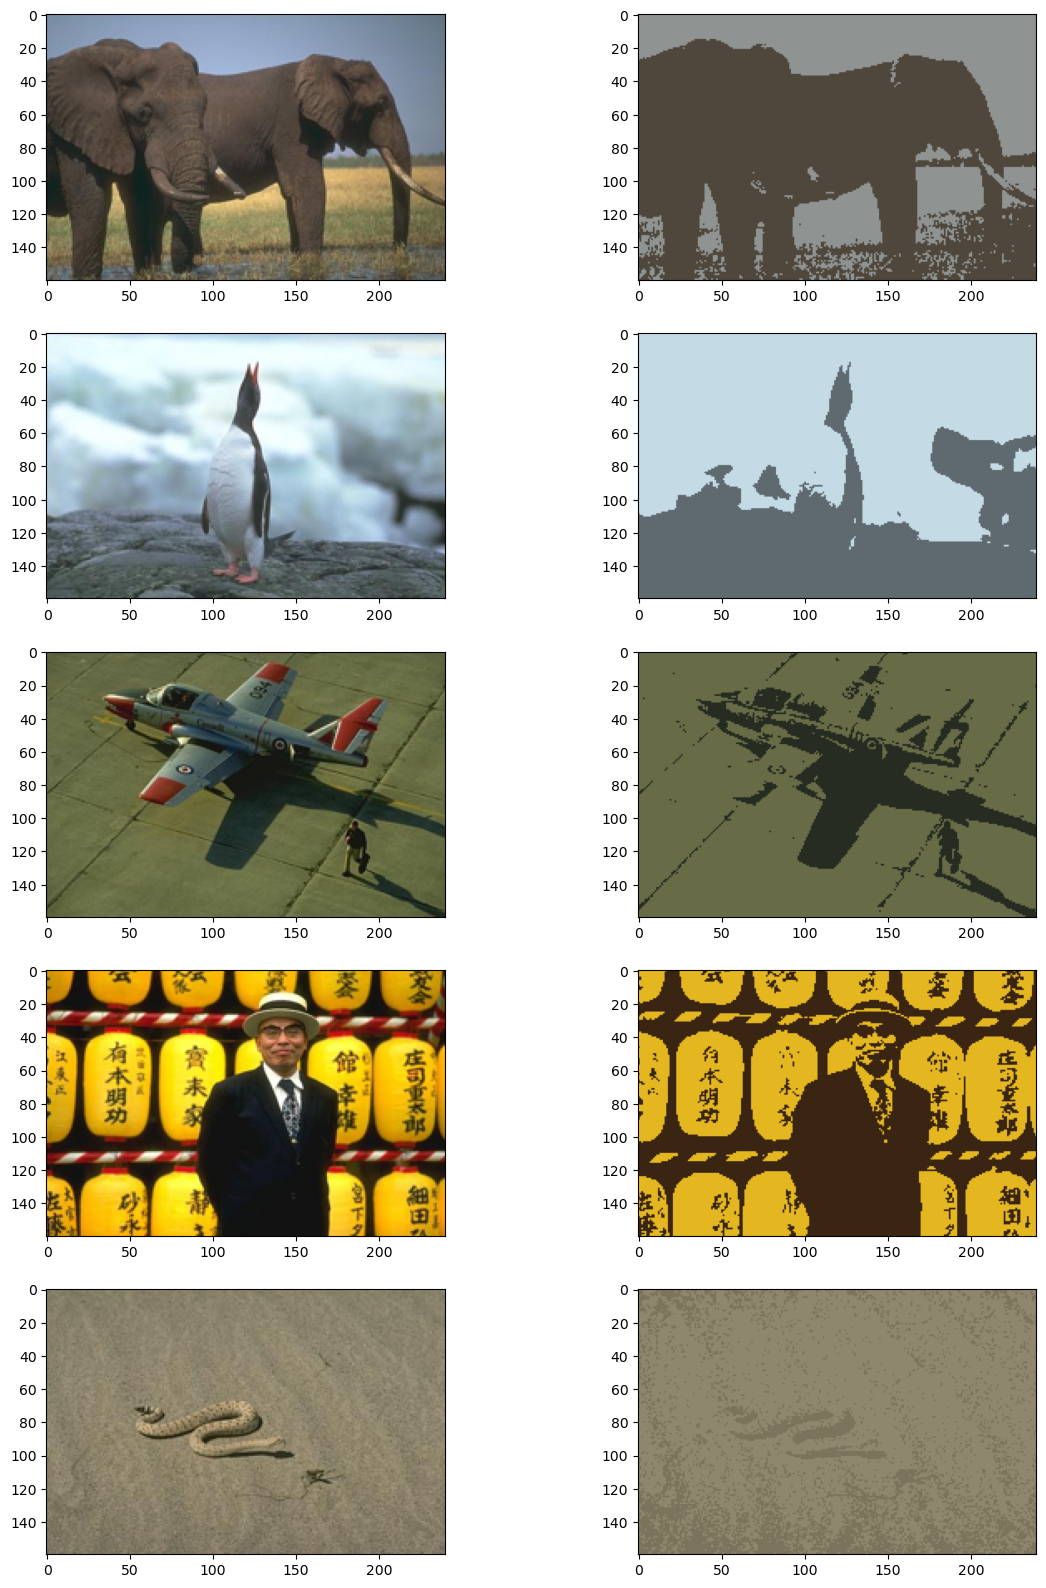

In [56]:
fig,axes=plt.subplots(5,2,figsize=(14,20))
for i in range(5):
    axes[i,0].imshow(images[i])
    axes[i,1].imshow(k_means_segm(images[i],k=2))

In [89]:
np.random.rand(1)[0]

0.37688093976587667

# Problem 3(a)

In [250]:
def 𝑔𝑒𝑛𝑒𝑟𝑎𝑡𝑒𝑃𝑜𝑖𝑛𝑡𝐹𝑟𝑜𝑚𝑅𝑎𝑛𝑑𝑜𝑚𝐶𝑙𝑢𝑠𝑡𝑒𝑟( ):
    data=[(0, 0, 10),(0, 50, 15),(50, 0, 15),(0,-50, 15),(-50, 0, 15),(35, 35, 15),
       (35,-35, 15),(-35, 35, 15),(-35,-35, 15),(0, 100, 20),(100, 0, 20),
       (0,-100, 20),(-100, 0, 20),(70, 70, 20),(70,-70, 20),(-70, 70, 20),(-70,-70, 20)]
    idx=np.random.randint(0,len(data))
    cent_rad=np.array(data[idx])
    cent_x=cent_rad[0]
    cent_y=cent_rad[1]
    rad=cent_rad[2]
    theta=np.random.rand(1)[0]*2*np.pi
    r=np.random.rand(1)[0]*rad
    point=np.array([[cent_x+r*np.cos(theta)],[cent_y+r*(np.sin(theta))]])
    return point,cent_rad

[[  -2.44598695]
 [-107.19168647]] [   0 -100   20]


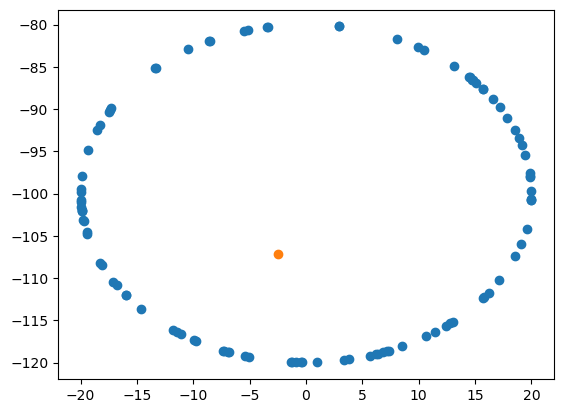

In [251]:
a,b=𝑔𝑒𝑛𝑒𝑟𝑎𝑡𝑒𝑃𝑜𝑖𝑛𝑡𝐹𝑟𝑜𝑚𝑅𝑎𝑛𝑑𝑜𝑚𝐶𝑙𝑢𝑠𝑡𝑒𝑟()
print(a,b)
angles=np.random.uniform(0,2*np.pi,100)
x1=b[0]+b[2]*(np.cos(angles))
y1=b[1]+b[2]*(np.sin(angles))
plt.scatter(x1,y1)
plt.scatter(a[0],a[1])
plt.show()

In [252]:
data=[(0, 0, 10),(0, 50, 15),(50, 0, 15),(0,-50, 15),(-50, 0, 15),(35, 35, 15),
       (35,-35, 15),(-35, 35, 15),(-35,-35, 15),(0, 100, 20),(100, 0, 20),
       (0,-100, 20),(-100, 0, 20),(70, 70, 20),(70,-70, 20),(-70, 70, 20),(-70,-70, 20)]
idx=np.random.choice(range(len(data)))
idx

1

In [253]:
np.random.randint(0,18)

2

In [254]:
len(data)

17

# Problem 3(b)

The data point 𝑥i ∈ 𝑪i (𝑖 = 1 … 𝑁) at each instant is obtained using
the function 𝑔𝑒𝑛𝑒𝑟𝑎𝑡𝑒𝑃𝑜𝑖𝑛𝑡𝐹𝑟𝑜𝑚𝑅𝑎𝑛𝑑𝑜𝑚𝐶𝑙𝑢𝑠𝑡𝑒𝑟( ). Perform
incremental clustering with default variance 𝑣d = 10 and Chebychev
inequality threshold 𝜆 = 3. As the number of clusters increase beyond
50, drop the cluster with lowest weight value (𝜋), so that at any given
iteration, there are a maximum of 𝐾 = 50 clusters. Plot the clusters as
differently coloured ellipses after every 100 iterations.

In [255]:
def alpha(t,threshold=100):
    if t<=threshold:
        return 1/(t+1)
    else:
        return 1/threshold

1
2
3
4


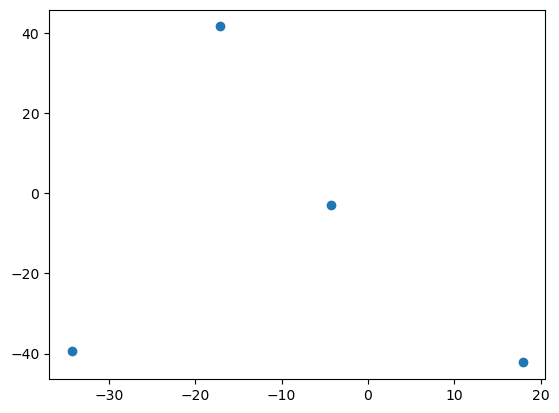

4


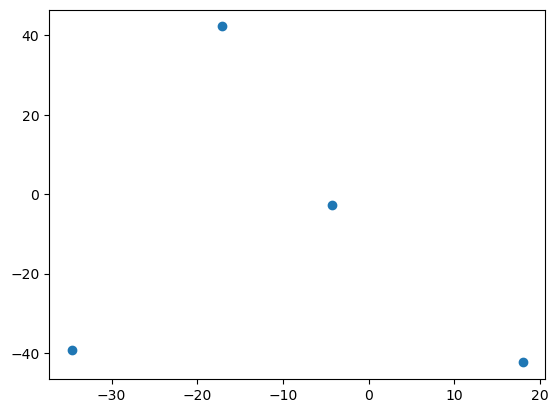

4


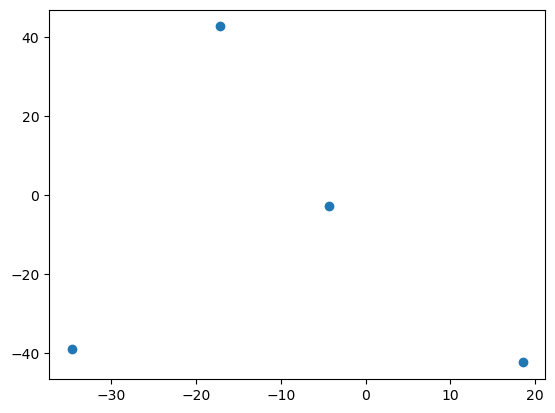

4


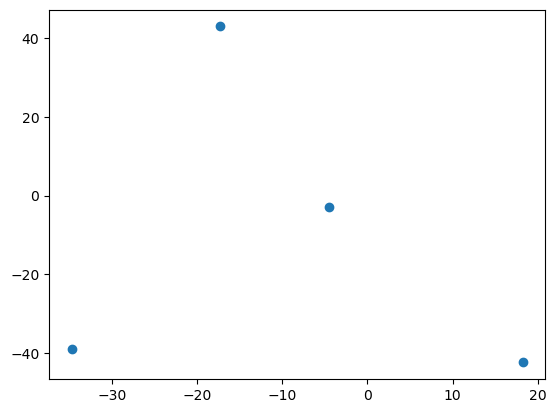

In [457]:
v_d,threshold,prior,max_K=10,3,1,50
x_0=𝑔𝑒𝑛𝑒𝑟𝑎𝑡𝑒𝑃𝑜𝑖𝑛𝑡𝐹𝑟𝑜𝑚𝑅𝑎𝑛𝑑𝑜𝑚𝐶𝑙𝑢𝑠𝑡𝑒𝑟( )[0]
cluster_means=np.array(x_0)
cluster_vars=np.array([v_d])
cluster_priors=np.array([prior])

for t in range(1,50000):
    x_t=𝑔𝑒𝑛𝑒𝑟𝑎𝑡𝑒𝑃𝑜𝑖𝑛𝑡𝐹𝑟𝑜𝑚𝑅𝑎𝑛𝑑𝑜𝑚𝐶𝑙𝑢𝑠𝑡𝑒𝑟( )[0]
    d_t=np.linalg.norm((x_t-cluster_means)**2,axis=0)/cluster_vars
    J_t=d_t < threshold**2
    if int(J_t.sum())!=0:
        r=np.argmin(d_t)
        # Prior update
        cluster_priors=(1-1/(t+1))*cluster_priors
        cluster_priors[r]+=1/(t+1)
        # Variance update
        beta_r_t=(1/(t+1))/cluster_priors[r]
        cluster_vars[r]=(1-beta_r_t)*(cluster_vars[r]+beta_r_t*(np.linalg.norm((x_t-cluster_means[:,r]))**2))
        # Mean update
        cluster_means[:,r]=(1-beta_r_t)*cluster_means[:,r]+(beta_r_t)*x_t.reshape(-1,2)
    else:
        if len(cluster_priors)<=50:
            print(len(cluster_priors))
            cluster_means=np.hstack((cluster_means,x_t))
            cluster_vars=np.hstack((cluster_vars,v_d))
            cluster_priors=np.hstack((cluster_priors,1/(t+1)))
        else:
            pass
    if t%10000==0:
        print(len(cluster_means[0,:]))
        plt.scatter(cluster_means[0,:],cluster_means[1,:])
        
        plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


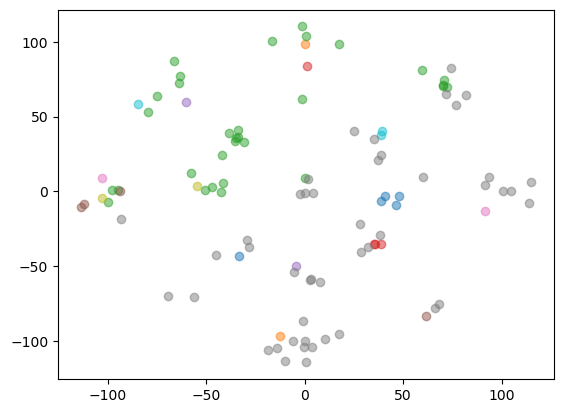

20


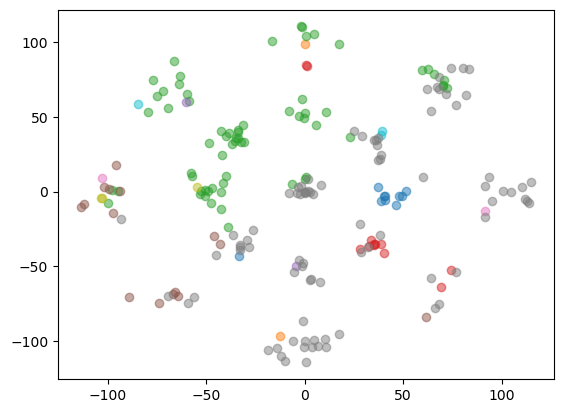

20


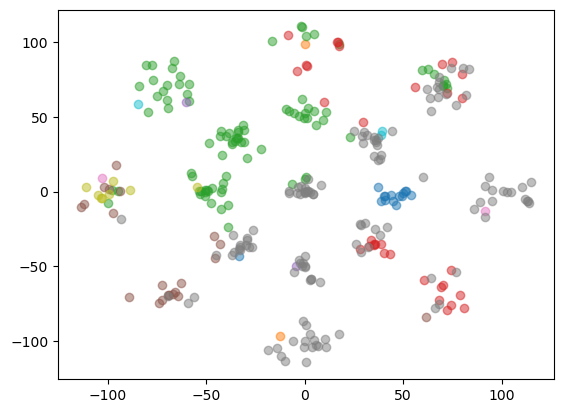

20


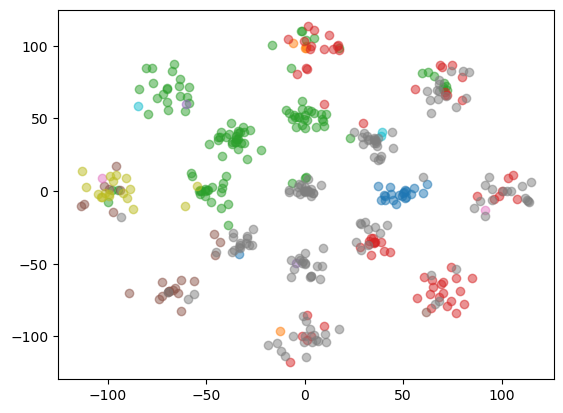

20


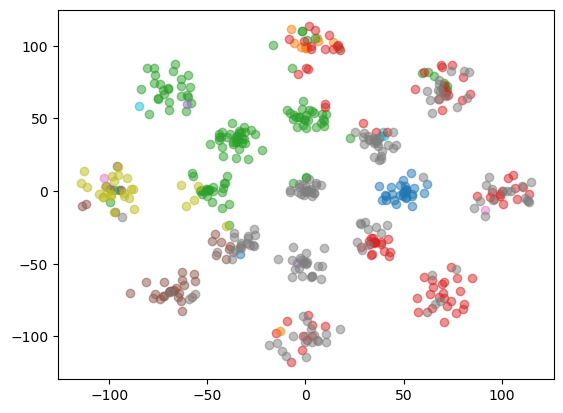

20


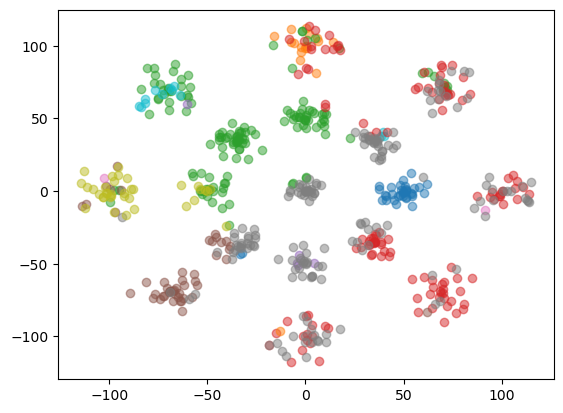

20


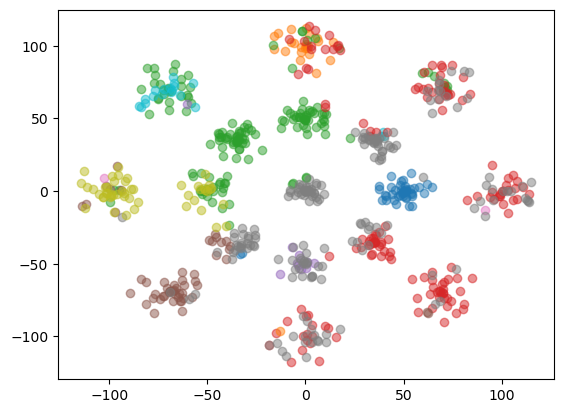

20


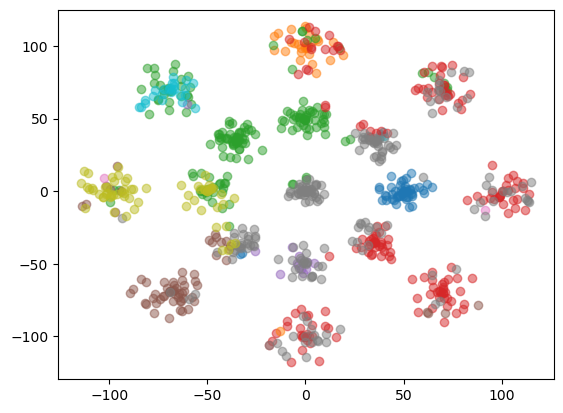

20


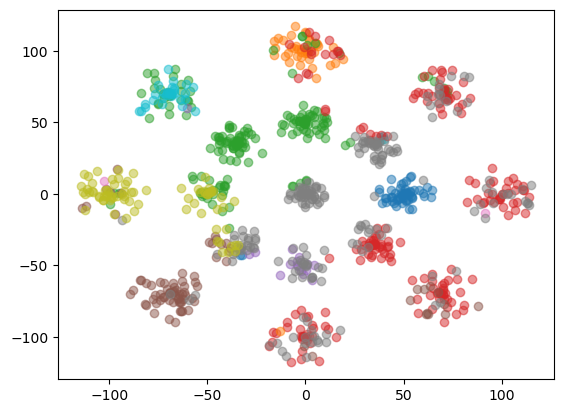

In [460]:
v_d,threshold,prior,max_K=10,3,1,50
x_0=𝑔𝑒𝑛𝑒𝑟𝑎𝑡𝑒𝑃𝑜𝑖𝑛𝑡𝐹𝑟𝑜𝑚𝑅𝑎𝑛𝑑𝑜𝑚𝐶𝑙𝑢𝑠𝑡𝑒𝑟( )[0]
default_var=np.array([[[v_d,0],[0,v_d]]])
cluster_means=np.array(x_0)
cluster_vars=default_var.copy()
cluster_priors=np.array([prior])
cluster_elems=[[x_0]]
for t in range(1,1000):
    x_t=𝑔𝑒𝑛𝑒𝑟𝑎𝑡𝑒𝑃𝑜𝑖𝑛𝑡𝐹𝑟𝑜𝑚𝑅𝑎𝑛𝑑𝑜𝑚𝐶𝑙𝑢𝑠𝑡𝑒𝑟( )[0]
    k=cluster_means.shape[1]
    d_t=np.zeros(k)
    for i in range(k):
        d_t[i]=np.dot((x_t-cluster_means[:,i].reshape(2,1)).T,np.dot(np.linalg.inv(cluster_vars[i]),(x_t-cluster_means[:,i].reshape(2,1))))[0][0]
    J_t=d_t < threshold**2
    if int(J_t.sum())!=0:
        r=np.argmin(d_t)
        cluster_elems[r].append(x_t)
        # Prior update
        cluster_priors=(1-1/(t+1))*cluster_priors
        cluster_priors[r]+=1/(t+1)
        # Variance update
        beta_r_t=(1/(t+1))/cluster_priors[r]
        cluster_vars[r]=(1-beta_r_t)*(cluster_vars[r]+beta_r_t*(np.dot(x_t-cluster_means[:,r],(x_t-cluster_means[:,r]).T)))
        # Mean update
        cluster_means[:,r]=(1-beta_r_t)*cluster_means[:,r]+(beta_r_t)*x_t.reshape(-1,2)
    else:
        if len(cluster_priors)<50:
            print(len(cluster_priors))
            cluster_elems.append([x_t])
            cluster_means=np.hstack((cluster_means,x_t))
            cluster_vars=np.concatenate((cluster_vars, default_var), axis=0)
            cluster_priors=np.hstack((cluster_priors,1/(t+1)))
        else:
            pass
    if t%100==0:
        k=cluster_means.shape[1]
        print(k)
        for i in range(len(cluster_elems)):
            plt.scatter(np.array(cluster_elems[i])[:,0],np.array(cluster_elems[i])[:,1],alpha=0.5)
            #plt.scatter(cluster_means[0,i],cluster_means[1,i])
        plt.show()

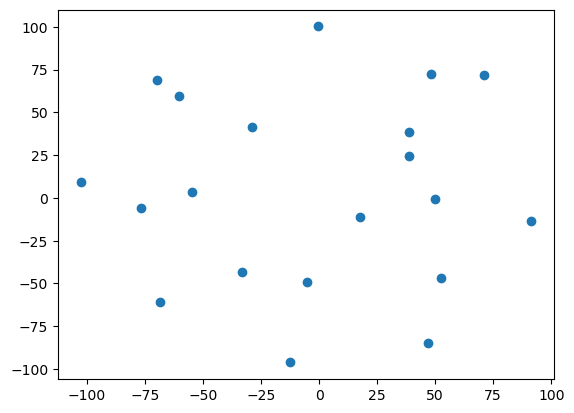

In [461]:
plt.scatter(cluster_means[0,:],cluster_means[1,:])

In [375]:
cluster_elems[10]

[array([[33.96433991],
        [28.31729032]]),
 array([[27.63160964],
        [31.94900527]]),
 array([[32.55576822],
        [32.13740665]]),
 array([[34.81475351],
        [35.29914413]]),
 array([[35.6720467 ],
        [34.66823743]]),
 array([[29.20527424],
        [29.52086968]]),
 array([[29.25758404],
        [24.80607412]]),
 array([[23.57063598],
        [29.4402749 ]]),
 array([[30.87941745],
        [25.41709968]]),
 array([[30.84363572],
        [26.42271826]]),
 array([[25.24464079],
        [26.5075473 ]]),
 array([[31.53936458],
        [26.01663321]]),
 array([[25.35101648],
        [34.49813817]]),
 array([[25.91180432],
        [27.37451256]]),
 array([[34.54867037],
        [29.91561992]]),
 array([[22.6522846 ],
        [32.69899246]]),
 array([[25.45807197],
        [27.29262545]]),
 array([[28.75204602],
        [27.74037837]]),
 array([[22.24907439],
        [32.83504501]]),
 array([[26.75697181],
        [31.98123747]]),
 array([[28.74884458],
        [36.08566

In [444]:
cluster_vars

array([[[   10,     0],
        [    0,    10]],

       [[   10,     0],
        [    0,    10]],

       [[  880,   249],
        [  249,   744]],

       [[   10,     0],
        [    0,    10]],

       [[   10,     0],
        [    0,    10]],

       [[    3,     0],
        [    0,     1]],

       [[   10,     0],
        [    0,    10]],

       [[   10,     0],
        [    0,    10]],

       [[   26,     0],
        [    0,    25]],

       [[ 7655,    41],
        [   41,  7118]],

       [[   10,     0],
        [    0,    10]],

       [[ 4171,   220],
        [  220,  3610]],

       [[   22,     0],
        [    0,    21]],

       [[    0,     0],
        [    0,     0]],

       [[10020,  -131],
        [ -131,  7649]],

       [[ 7157,   591],
        [  591,  3358]],

       [[  118,    39],
        [   39,   119]]])